In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from lwa_antpos import reading
from scipy.optimize import curve_fit
import scipy.stats as st
import math
import argparse
import yaml

Read antpos from default source


# Load some data
The cosmic ray system reads out 20 microseconds of buffered data for every event that triggers a readout.  This data is transmitted over Ethernet, and each individual Ethernet packet contains data from one antenna for one event.  Thus, a complete event consists of 704 packets.  Since any SNAP2 board can trigger the data to be read out, the ethernet packets are not always in the same antenna-order for different events.  

The code that captures this data can accumulate packets from many events into one data file.

The example file below has data from 704000 ethernet packets, corresponding to roughly 1000 events that triggered the buffer readout.  It is roughly (rather than exactly) 1000 events because occasionally some packets are lost or an event is fragmented across files.  

The parsefile function loads the binary data and puts the header and timeseries information for each packet into a dictionary, and returns the list of dictionaries. 

Below, I plot the timeseries of raw ADC samples contained in the first packet, and print the name of the antenna that it came from. Please note that the "antenna_id" field from the packet header must be converted to a snap input number before using the mapping function from lwa_antpos.

In [4]:
records=parsefile('/lustre/kplant/2024May1/overnight1714651646.3453243.dat')



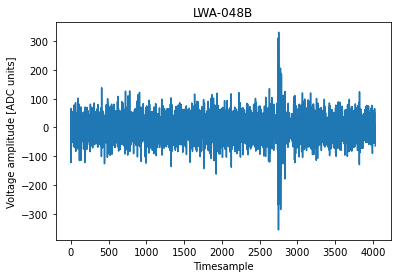

In [25]:
record=records[0]
first_timeseries=record['data']
plt.plot(first_timeseries)
plt.xlabel('Timesample')
plt.ylabel('Voltage amplitude [ADC units]')

snap_input=packet_ant_id_2_snap_input(record['antenna_id'])
snap_board_number=record['board_id']
name=mapping.snap2_to_antpol(snap_board_number,snap_input)

plt.title(name)
plt.show()

# Organize the data into discrete events
 The distinguishevents function organizes that list into sets of records that correspond to individual events, using the timestamps in the packet header data. It returns sets of indices that of records corresponding to the same event, not a copy of the records themselves.

In [9]:
sets_of_event_indices=distinguishevents(records,200)


# Plot data from one RFI event
Below, I select one individual RFI event (the tenth one) and make a couple illustrative plots.  See cr_data_inspection_functions.py for details of the optional arguments and for other handy plotting functions.

Note that alternatively if you have the indices for the records of an event, you can use parsefile to load only that one event and not the whole file.

In [10]:
#select the records for one event
indices_for_first_event=sets_of_event_indices[10]
event_records=[records[i] for i in indices_for_first_event]
print(len(event_records))

704


This event has 704 records, as it should. Since snapshots are transmitted with one ethernet packet per antenna, if any packets are missing some antennas' data will be lost but data from the rest of the array is still usable. However, some of the functions I show below for making quick plots currently won't work with events that are missing any packets.

In [14]:
#here I load some array map information to be able to make colormaps of the whole array.
#I'm planning to simplify this step in the future.
lwa_df = reading.read_antpos()
namedict=build_mapping_dictionary(lwa_df)
array_map=pd.read_csv('/home/kplant/lwa-cosmic-rays/array-map-5-22-2023.csv')  #replace this with your path
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]


Below I plot a quick estimate of the event signal to noise for the whole array, excluding antennas that don't meet certain signal quality cuts.  Normally I require the rms to be between 25 and 45 ADC units, but I've relaxed that here in order to show a bad RFI.

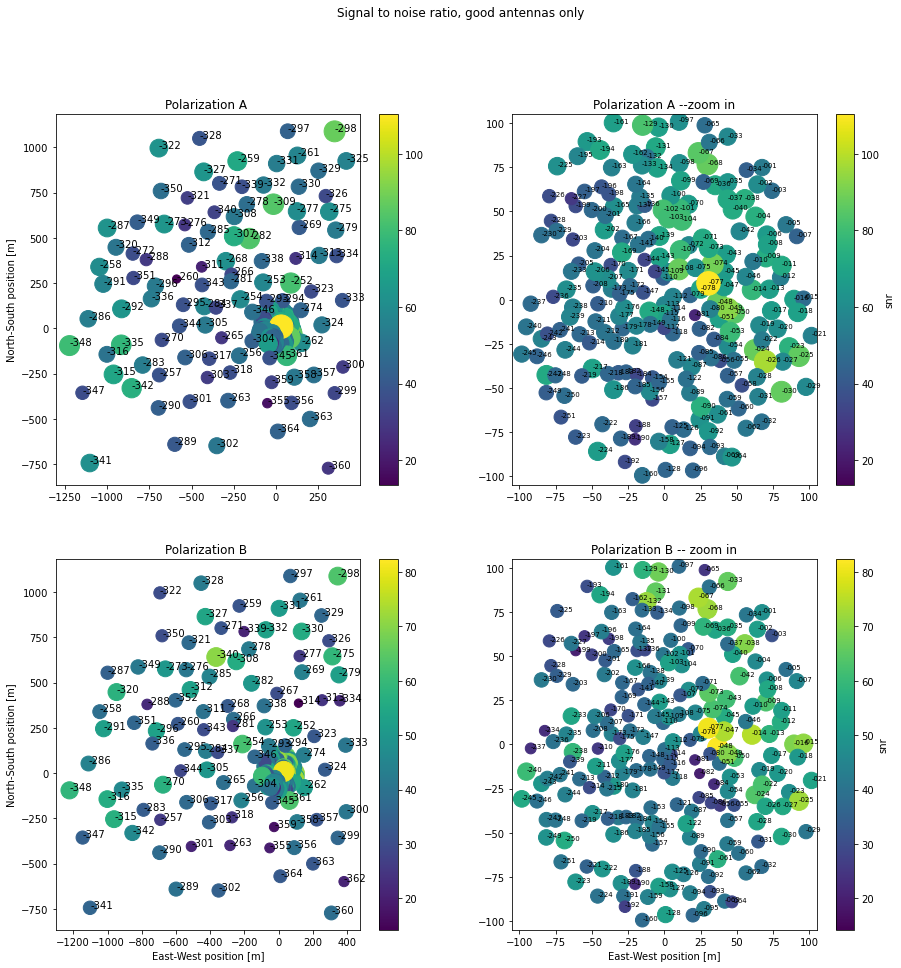

In [16]:
plot_event_snr(event_records,arraymapdictionaries,namedict,minimum_ok_rms=15,maximum_ok_rms=60,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True)

 Below, I make timeseries and spectra plots for a few antennas.

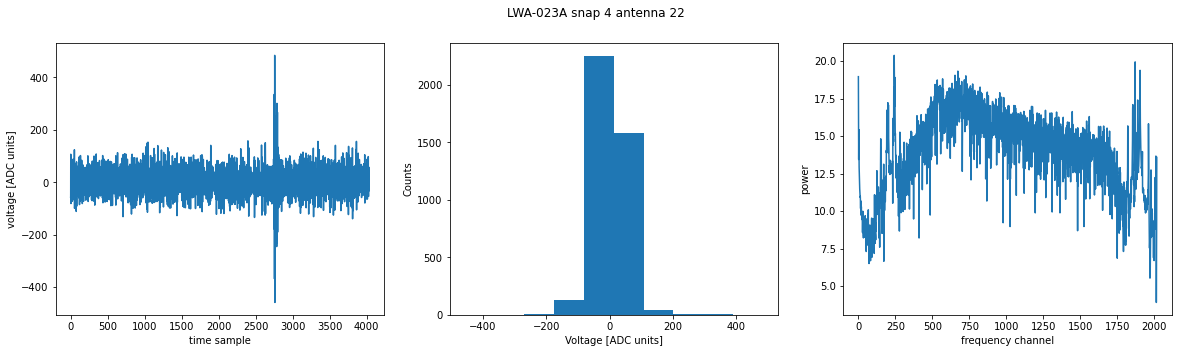

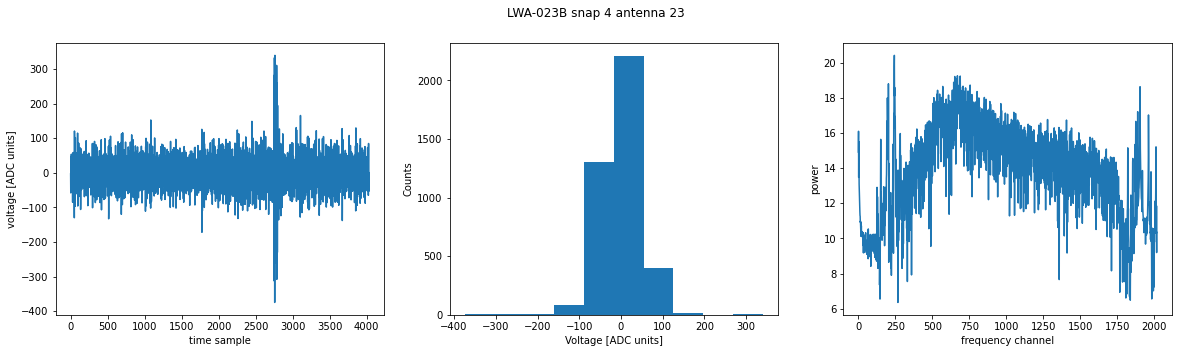

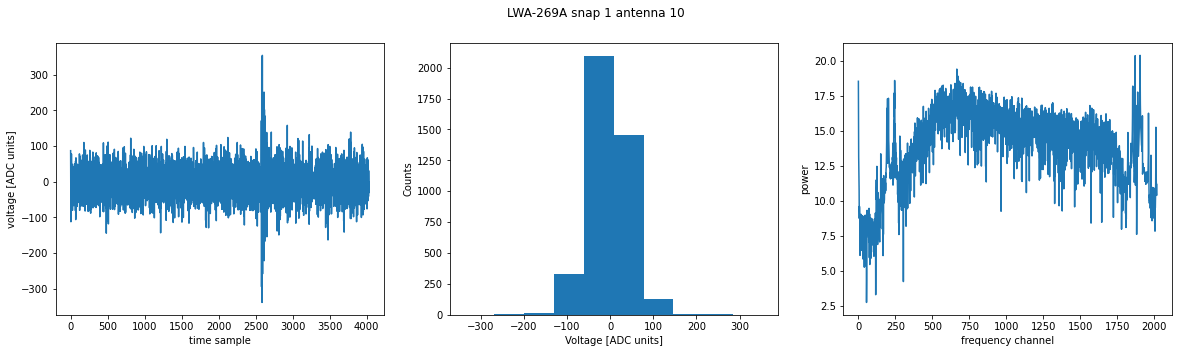

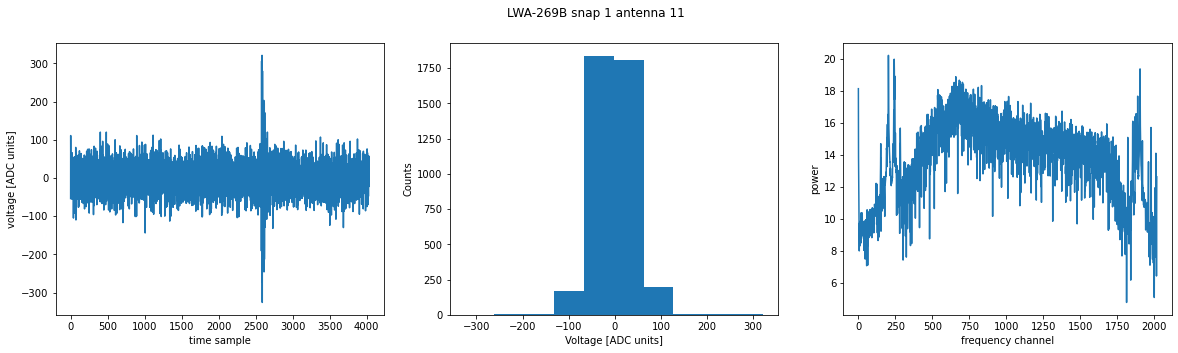

In [17]:

plot_select_antennas(event_records,['LWA-023A','LWA-023B','LWA-269A','LWA-269B'])
#plot_event_snr(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,Filter=h)



Below I define some filter coefficients to suppress RFI at the high and low ends of the band.

In [21]:

h=np.asarray([ 4.92911114e-05,
              1.22554976e-02,
              8.52896162e-02,
              -6.31362632e-02,
              -2.14894130e-02,
              -6.75559577e-02,
              -1.77061188e-02,
              8.08821515e-02,
              -1.43581483e-02,
              9.38352028e-02,
              -2.80577772e-01,
              -1.29748809e-01,
              5.01393724e-01,
              -1.29748809e-01,
              -2.80577772e-01,
              9.38352028e-02,
              -1.43581483e-02,
              8.08821515e-02,
              -1.77061188e-02,
              -6.75559577e-02,
              -2.14894130e-02,
              -6.31362632e-02,
              8.52896162e-02,
              1.22554976e-02,
              4.92911114e-05])



Next, I plot the event for both polarizations of one antenna, with panels that progressively zoom in around the peak.  This same function could be used to compare two signals from different antennas; it doesn't have to be a polarization pair.

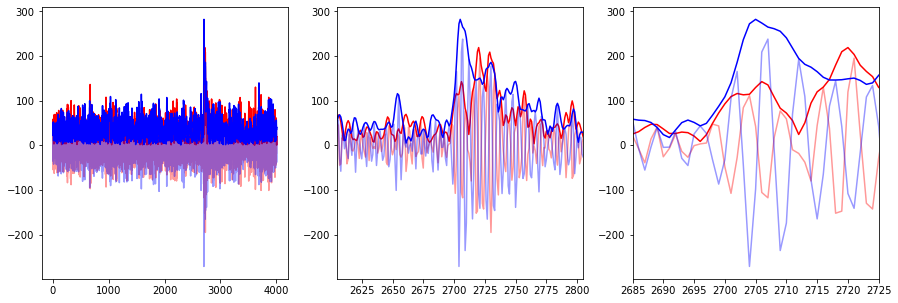

In [24]:
plt.figure(figsize=(15,5))
waveform_compare_plot(event_records,'LWA-077A','LWA-077B',h)